In [70]:
import numpy as np
import cv2
import open3d as o3d
import open3d.visualization.rendering as rendering

from utils.meta_io import fetch_scene_object_by_image_id
from utils.intrinsic_fetcher import IntrinsicFetcher
from scipy.interpolate import griddata

In [4]:
scene_by_image_id = fetch_scene_object_by_image_id('v2_3d')
intrinsic_fetcher = IntrinsicFetcher()

In [121]:
scene_by_image_id = fetch_scene_object_by_image_id('v2_3d')
scene = scene_by_image_id['010330']
print(scene.rgb_path)

/home/junha/data/sunrefer/official/SUNRGBD/realsense/shr/2014_12_18-16_26_34-1311000073/image/0000063.jpg


In [18]:
render_to_image('000001_1_0')

TypeError: add_geometry(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cuda.pybind.visualization.rendering.Open3DScene, name: str, geometry: open3d.cuda.pybind.geometry.Geometry3D, material: open3d.cuda.pybind.visualization.rendering.MaterialRecord, add_downsampled_copy_for_fast_rendering: bool = True) -> None
    2. (self: open3d.cuda.pybind.visualization.rendering.Open3DScene, name: str, geometry: open3d.cuda.pybind.t.geometry.Geometry, material: open3d.cuda.pybind.visualization.rendering.MaterialRecord, add_downsampled_copy_for_fast_rendering: bool = True) -> None

Invoked with: <open3d.cuda.pybind.visualization.rendering.Open3DScene object at 0x7f598b9832b0>, 'pcd', PointCloud with 280687 points.

In [17]:
def render_to_image(uniq_id: str):
    image_id, object_id, anno_id = uniq_id.split('_')
    object_id = int(object_id)
    scene = scene_by_image_id[image_id]
    fx, fy, cx, cy, height, width = intrinsic_fetcher[image_id]

    render = rendering.OffscreenRenderer(width, height)
    color_raw = cv2.imread(str(scene.rgb_path), cv2.IMREAD_COLOR)
    depth_raw = cv2.imread(str(scene.depth_path), cv2.IMREAD_UNCHANGED)
    rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(
        o3d.geometry.Image(color_raw),
        o3d.geometry.Image(depth_raw),
        convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        image=rgbd_image,
        intrinsic=o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy))
    color = rendering.MaterialRecord()
    color.base_color = [0, 0, 0, 1]
    color.shader = 'defaultLit'
    render.scene.add_geometry('pcd', pcd, color)

    Rt = np.eye(4, dtype=np.float32)
    Rt[:3, :3] = scene.extrinsics
    render.setup_camera(o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy), Rt)
    img = render.render_to_image()
    o3d.io.write_image('test.png', img, 9)

    # Tyz = np.array([
    #     [1, 0, 0, 0],
    #     [0, 0, 1, 0],
    #     [0, -1, 0, 0],
    #     [0, 0, 0, 1]], dtype=np.float32)
    # Rt = Tyz @ Rt




    # o3d_obj_list = []
    # o3d_obj_list.append(pcd)
    #
    # coord_frame_orig = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
    # # coord_frame_revised = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
    # # coord_frame_revised.transform(np.linalg.inv(Rt))
    # #
    # o3d_obj_list.append(coord_frame_orig)
    # # o3d_obj_list.append(coord_frame_revised)
    # #
    # # for oid, bbox_3d in enumerate(scene.gt_3d_bbox):
    # #     # class_name = bbox_3d.class_name[0]  # str
    # #     centroid = bbox_3d.centroid[0]  # (3, )
    # #     basis = bbox_3d.basis  # (3, 3)
    # #     coeffs = bbox_3d.coeffs[0]  # (3, )
    # #
    # #     if self.highlight and oid == object_id:
    # #         color = [0, 1, 0]
    # #         radius = 0.03
    # #     else:
    # #         color = [1, 0, 0]
    # #         radius = 0.015
    # #
    # #     line_mesh = create_line_mesh(centroid, basis, coeffs, aabb=self.aabb, color=color, radius=radius)
    # #     for s in line_mesh.cylinder_segments:
    # #         s.transform(np.linalg.inv(Rt))
    # #     o3d_obj_list += line_mesh.cylinder_segments
    # o3d.visualization.draw_geometries(o3d_obj_list)a

In [61]:
def compute_3d_bbox(uniq_id: str):
    image_id, object_id, anno_id = uniq_id.split('_')
    object_id = int(object_id)
    scene = scene_by_image_id[image_id]
    fx, fy, cx, cy, height, width = intrinsic_fetcher[image_id]

    Rt = np.eye(4, dtype=np.float32)
    Rt[:3, :3] = scene.extrinsics

    print(scene.extrinsics)

    # Tyz = np.array([
    #     [1, 0, 0, 0],
    #     [0, 0, 1, 0],
    #     [0, -1, 0, 0],
    #     [0, 0, 0, 1]], dtype=np.float32)
    # Rt = Tyz @ Rt

    # Rt = np.array([
    #     [1, 0, 0, 0],
    #     [0, 0, 1, 0],
    #     [0, -1, 0, 0],
    #     [0, 0, 0, 1]], dtype=np.float32)

    print(Rt)
    print(',\n'.join(list(map(str, np.reshape(np.linalg.inv(Rt), (16, )).tolist()))))

    color_raw = cv2.imread(str(scene.rgb_path), cv2.IMREAD_COLOR)
    color_raw = cv2.cvtColor(color_raw, cv2.COLOR_BGR2RGB)
    depth_raw = cv2.imread(str(scene.depth_path), cv2.IMREAD_UNCHANGED)
    rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(
        o3d.geometry.Image(color_raw),
        o3d.geometry.Image(depth_raw),
        convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        image=rgbd_image,
        intrinsic=o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy))
        # extrinsic=Rt)
    o3d.io.write_point_cloud("pcd.ply", pcd)

    # o3d_obj_list = []
    # o3d_obj_list.append(pcd)

    coord_frame_orig = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
    viewer = o3d.visualization.Visualizer()
    viewer.create_window('viewer', visible=True, width=width, height=height)
    viewer.add_geometry(pcd)
    viewer.add_geometry(coord_frame_orig)
    cam = viewer.get_view_control().convert_to_pinhole_camera_parameters()
    cam.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    print(cam.intrinsic.intrinsic_matrix)
    # print(cam.intrinsic)
    # cam.extrinsic = Rt  #np.linalg.inv(Rt)
    # print(cam)
    viewer.get_view_control().convert_from_pinhole_camera_parameters(cam)
    viewer.run()
    viewer.capture_screen_image('screen.png')
    viewer.destroy_window()

    # o3d.visualization.draw_geometries(o3d_obj_list)

In [62]:
compute_3d_bbox('000001_1_0')

[[ 0.979589  0.200614  0.012593]
 [-0.200614  0.97182   0.123772]
 [ 0.012593 -0.123772  0.992231]]
[[ 0.979589  0.200614  0.012593  0.      ]
 [-0.200614  0.97182   0.123772  0.      ]
 [ 0.012593 -0.123772  0.992231  0.      ]
 [ 0.        0.        0.        1.      ]]
0.9795898199081421,
-0.20061418414115906,
0.012592272832989693,
0.0,
0.20061418414115906,
0.9718203544616699,
-0.12377206981182098,
0.0,
0.012592272832989693,
0.12377206981182098,
0.9922305345535278,
0.0,
0.0,
0.0,
0.0,
1.0
[[529.5   0.  365. ]
 [  0.  529.5 265. ]
 [  0.    0.    1. ]]
[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


In [118]:
def convert_raw_depth(raw_depth):
    """Numpy implementation of SUNRGBD depth processing."""
    shift_depth = np.bitwise_or(np.right_shift(raw_depth, 3), np.left_shift(raw_depth, 13))
    float_depth = shift_depth.astype(dtype=np.float32) / 1000.
    float_depth[float_depth > 7.0] = 0.
    return float_depth


def convert_pcd(raw_depth, fx, fy, cx, cy):
    m = raw_depth > 0
    zz = convert_raw_depth(raw_depth)
    mx = np.linspace(0, raw_depth.shape[1] - 1, raw_depth.shape[1])
    my = np.linspace(0, raw_depth.shape[0] - 1, raw_depth.shape[0])
    rx = np.linspace(0., 1., raw_depth.shape[1])
    ry = np.linspace(0., 1., raw_depth.shape[0])
    rx, ry = np.meshgrid(rx, ry)
    xx, yy = np.meshgrid(mx, my)
    xx = (xx - cx) * zz / fx
    yy = (yy - cy) * zz / fy
    pcd = np.stack((xx, yy, zz), axis=-1)
    return pcd, m, rx, ry


def interpolate_projected_points(uniq_id: str):
    image_id, object_id, anno_id = uniq_id.split('_')
    object_id = int(object_id)
    scene = scene_by_image_id[image_id]
    fx, fy, cx, cy, height, width = intrinsic_fetcher[image_id]
    print(fx, fy, cx, cy, height, width)

    color_raw = cv2.imread(str(scene.rgb_path), cv2.IMREAD_COLOR)
    color_raw = cv2.cvtColor(color_raw, cv2.COLOR_BGR2RGB)
    depth_raw = cv2.imread(str(scene.depth_path), cv2.IMREAD_UNCHANGED)
    color_np = np.asarray(color_raw, dtype=np.uint8)
    depth_np = np.asarray(depth_raw, dtype=np.uint16)
    pcd, mask, rx, ry = convert_pcd(raw_depth=depth_np, fx=fx, fy=fy, cx=cx, cy=cy)

    Rt = np.array(scene.extrinsics)
    # Rt = np.array([
    #     [1, 0, 0],
    #     [0, 0, 1],
    #     [0, -1, 0]], dtype=np.float32)
    # Rt = Tyz @ Rt

    # print(Rt)
    # print(np.linalg.inv(Rt))
    pcd = pcd @ np.transpose(Rt)
    # pcd = pcd @ np.linalg.inv(Rt)

    print(Rt.shape)
    print(pcd.shape)
    print(mask.shape)

    mask_nz = np.abs(pcd[..., 2]) > 1e-6
    pcd[mask_nz, 0] = fx * pcd[mask_nz, 0] / pcd[mask_nz, 2] + cx
    pcd[mask_nz, 1] = fy * pcd[mask_nz, 1] / pcd[mask_nz, 2] + cy
    sampled_x = np.reshape(pcd[mask_nz, 0], (-1, ))
    sampled_y = np.reshape(pcd[mask_nz, 1], (-1, ))
    sampled_r = np.reshape(color_np[mask_nz, 0], (-1, ))
    sampled_g = np.reshape(color_np[mask_nz, 1], (-1, ))
    sampled_b = np.reshape(color_np[mask_nz, 2], (-1, ))

    print(np.min(sampled_x), np.max(sampled_x))
    print(np.min(sampled_y), np.max(sampled_y))
    offset_x = round(-np.min(sampled_x)) if np.min(sampled_x) < 0 else 0
    offset_y = round(-np.min(sampled_y)) if np.min(sampled_y) < 0 else 0
    size_x = round(np.max(sampled_x))
    size_y = round(np.max(sampled_y))


    new_image = np.zeros((height, width, 3), dtype=np.uint8)



    # reproject to 2D image again after transformation.
    from math import isnan

    # sample_x = np.zeros((height * width, ), dtype=np.float32)
    # sample_y = np.zeros((height * width, ), dtype=np.float32)
    # mask_trs = np.zeros((height, width), dtype=bool)
    # for rr in range(pcd.shape[0]):
    #     for cc in range(pcd.shape[1]):
    #         if isnan(pcd[rr, cc, 0]) or isnan(pcd[rr, cc, 1]):
    #             continue
    #         xx = int(pcd[rr, cc, 0] + cx)
    #         yy = int(pcd[rr, cc, 1] + cy)
    #         sample_x[rr * pcd.shape[1] + cc] = pcd[rr, cc, 0]
    #         sample_y[rr * pcd.shape[1] + cc] = pcd[rr, cc, 1]
    #         # if rr == 0:
    #         #     print(rr, nr, cc, nc)
    #         if 0 <= xx < pcd.shape[1] and 0 <= yy < pcd.shape[0]:
    #             new_image[yy, xx, :] = color_np[rr, cc, :]
    #             mask_trs[yy, xx] = True


    # print(sample_x.shape, pcd.shape, grid_x.shape, grid_y.shape)
    # sampled_r = griddata((sample_x, sample_y), np.reshape(color_np[..., 0], (-1, )), (grid_x, grid_y))
    # sampled_g = griddata((sample_x, sample_y), np.reshape(color_np[..., 1], (-1, )), (grid_x, grid_y))
    # sampled_b = griddata((sample_x, sample_y), np.reshape(color_np[..., 2], (-1, )), (grid_x, grid_y))

    grid_x, grid_y = np.meshgrid(
        np.linspace(-offset_x, size_x-1, size_x + offset_x),
        np.linspace(-offset_y, size_y-1, size_y + offset_y))
    grid_r = griddata((sampled_x, sampled_y), sampled_r, (grid_x, grid_y))
    grid_g = griddata((sampled_x, sampled_y), sampled_g, (grid_x, grid_y))
    grid_b = griddata((sampled_x, sampled_y), sampled_b, (grid_x, grid_y))
    sampled_image = np.stack((grid_r, grid_g, grid_b), axis=-1)
    print(np.sum(np.isnan(sampled_image)))

    sampled_uimage = np.zeros(sampled_image.shape, dtype=np.uint8)
    nan_mask = ~np.isnan(sampled_image)
    sampled_uimage[nan_mask] = np.round(sampled_image[nan_mask])
    # print(sampled_uimage)

    # grid_Y = griddata(points, pcd[..., 1], (grid_x, grid_y))
    # grid_Z = griddata(points, pcd[..., 2], (grid_x, grid_y))


    # for i, rr in enumerate(range(pcd.shape[0])):
    #     for j, cc in enumerate(range(pcd.shape[1])):
    #         ir, ic = int(rr), int(cc)
    #         if 0 <= ir < pcd.shape[1] and 0 <= ic < pcd.shape[0]:
    #             new_image[ir, ic, :] = color_np[i, j, :]

    mask = mask.astype(np.uint8) * 255

    o3d.io.write_image('test.png', o3d.geometry.Image(new_image))
    o3d.io.write_image('mask.png', o3d.geometry.Image(mask))
    o3d.io.write_image('sampled.png', o3d.geometry.Image(sampled_uimage))



    # image = np.zeros((height, width, 3), dtype=np.uint8)

    # Rt = np.eye(4, dtype=np.float32)
    # Rt[:3, :3] = scene.extrinsics

    # rgbd_image = o3d.geometry.RGBDImage.create_from_sun_format(
    #     o3d.geometry.Image(color_raw),
    #     o3d.geometry.Image(depth_raw),
    #     convert_rgb_to_intensity=False)
    # pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    #     image=rgbd_image,
    #     intrinsic=o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy))
        # extrinsic=Rt)
    # o3d.io.write_point_cloud("pcd.ply", pcd)

    # o3d_obj_list = []
    # o3d_obj_list.append(pcd)

    # coord_frame_orig = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.6, origin=[0, 0, 0])
    # viewer = o3d.visualization.Visualizer()
    # viewer.create_window('viewer', visible=True, width=width, height=height)
    # viewer.add_geometry(pcd)
    # viewer.add_geometry(coord_frame_orig)
    # cam = viewer.get_view_control().convert_to_pinhole_camera_parameters()
    # cam.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    # print(cam.intrinsic.intrinsic_matrix)
    # # print(cam.intrinsic)
    # # cam.extrinsic = Rt  #np.linalg.inv(Rt)
    # # print(cam)
    # viewer.get_view_control().convert_from_pinhole_camera_parameters(cam)
    # viewer.run()
    # viewer.capture_screen_image('screen.png')
    # viewer.destroy_window()

    # o3d.visualization.draw_geometries(o3d_obj_list)

In [119]:
interpolate_projected_points('000001_1_0')

529.5 529.5 365.0 265.0 530 730
(3, 3)
(530, 730, 3)
(530, 730)
-21.462692953200985 787.4786958989614
50.626880465589124 689.6687446002368
499914


(400,) (400,) (100, 100)
(100, 100) (100, 100)


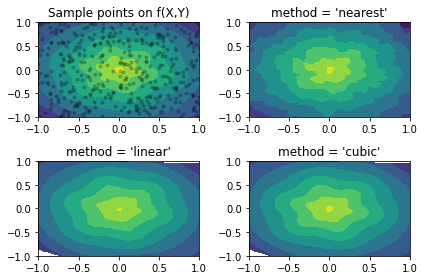

In [79]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

x = np.linspace(-1,1,100)
y =  np.linspace(-1,1,100)
X, Y = np.meshgrid(x,y)

def f(x, y):
    s = np.hypot(x, y)
    phi = np.arctan2(y, x)
    tau = s + s*(1-s)/5 * np.sin(6*phi)
    return 5*(1-tau) + tau

T = f(X, Y)
# Choose npts random point from the discrete domain of our model function
npts = 400
px, py = np.random.choice(x, npts), np.random.choice(y, npts)
print(px.shape, py.shape, T.shape)
print(X.shape, Y.shape)

fig, ax = plt.subplots(nrows=2, ncols=2)
# Plot the model function and the randomly selected sample points
ax[0,0].contourf(X, Y, T)
ax[0,0].scatter(px, py, c='k', alpha=0.2, marker='.')
ax[0,0].set_title('Sample points on f(X,Y)')

# Interpolate using three different methods and plot
for i, method in enumerate(('nearest', 'linear', 'cubic')):
    Ti = griddata((px, py), f(px,py), (X, Y), method=method)
    r, c = (i+1) // 2, (i+1) % 2
    ax[r,c].contourf(X, Y, Ti)
    ax[r,c].set_title("method = '{}'".format(method))

plt.tight_layout()
plt.show()

In [ ]:



import torch
# meta_dict = torch.load('/home/junha/data/sunrefer/meta.pt')
from pathlib import Path


root = Path('/home/junha/data/sunrefer/official/SUNRGBD/')
meta_dict = torch.load('/home/junha/data/sunrefer/new_meta.pt')

new_meta_dict = dict()
for i, (k, v) in enumerate(list(meta_dict.items())[:10]):
    print(i, k, v['seq_name'])
    # try:
    #     v['seq_name'] = str(Path(scene_by_image_id[k].seq_root).relative_to(root))
    # except:
    #     pass
    # new_meta_dict[k] = v

# import torch
# torch.save(new_meta_dict, '/home/junha/data/sunrefer/new_meta.pt')

In [3]:
import torch
from pathlib import Path
root = Path('/home/junha/data/sunrefer/official/SUNRGBD/')
meta_dict = torch.load('/home/junha/data/sunrefer/new_meta.pt')

In [1]:
from utils.meta_io import fetch_scene_object_by_image_id
scene_by_image_id = fetch_scene_object_by_image_id('v2_3d')

found seq_name: SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize
SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize 0000103.jpg 0000103.png
/home/junha/data/sunrefer/official/SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize
/home/junha/data/sunrefer/official/SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize/image/0000103.jpg
/home/junha/data/sunrefer/official/SUNRGBD/kv2/kinect2data/000002_2014-05-26_14-23-37_260595134347_rgbf000103-resize/depth/0000103.png
found seq_name: SUNRGBD/kv2/kinect2data/000003_2014-05-26_14-24-42_260595134347_rgbf000040-resize
SUNRGBD/kv2/kinect2data/000003_2014-05-26_14-24-42_260595134347_rgbf000040-resize 0000040.jpg 0000040.png
/home/junha/data/sunrefer/official/SUNRGBD/kv2/kinect2data/000003_2014-05-26_14-24-42_260595134347_rgbf000040-resize
/home/junha/data/sunrefer/official/SUNRGBD/kv2/kinect2data/000003_2014-05-26_14-24-42_26

In [10]:
import torch
meta_dict = torch.load('/home/junha/data/sunrefer/meta.pt')
new_meta_dict = dict()
for i, (k, v) in enumerate(list(meta_dict.items())):
    scene = scene_by_image_id[k]
    v['seq_name'] = str(scene.seq_root)[35:]
    new_meta_dict[k] = v
torch.save(new_meta_dict, '/home/junha/data/sunrefer/meta.pt')

In [13]:
md = torch.load('/home/junha/data/sunrefer/meta.pt')

In [15]:
md['000375']

{'seq_name': 'SUNRGBD/kv2/kinect2data/000741_2014-06-08_18-47-12_260595134347_rgbf000066-resize',
 'rgb_name': '0000066.jpg',
 'depth_name': '0000066.png',
 'E': array([[ 0.997721,  0.066553,  0.011153],
        [-0.066553,  0.943147,  0.325644],
        [ 0.011153, -0.325644,  0.945427]]),
 'intrinsic': 'k2',
 'obj_3d': [{'class_name': 'chair',
   'basis': array([[-0.31622777,  0.9486833 ,  0.        ],
          [ 0.95009181,  0.31197044,  0.        ],
          [ 0.        ,  0.        ,  1.        ]]),
   'coeffs': array([[0.2731058 , 0.32054319, 0.45      ]]),
   'centroid': array([[ 0.37727273,  1.96818182, -0.75      ]]),
   'orientation': array([[-0.95009181, -0.31197044,  0.        ]])},
  {'class_name': 'desk',
   'basis': array([[-0.11982016,  0.99279561,  0.        ],
          [-0.99340894, -0.11462411,  0.        ],
          [ 0.        ,  0.        ,  1.        ]]),
   'coeffs': array([[0.83485086, 0.3619343 , 0.38636364]]),
   'centroid': array([[-0.63678954,  2.011495